In [603]:
import numpy as np
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve, recall_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve, KFold, GridSearchCV, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

import pickle
import random


df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

#  Ссылка на результаты соревнований:
https://www.kaggle.com/competitions/playground-series-s4e1/leaderboard?tab=public

In [604]:
# отчет по метрикам
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [605]:
# функция для балансировки классов
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [606]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt.show()

In [607]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [608]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [609]:
scaler = StandardScaler()

In [610]:
df_train.head()

id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0  
2       0  
3       0  
4       0

In [611]:
np.sort(df_train['CustomerId'].unique())

array([15565701, 15565706, 15565714, ..., 15815660, 15815670, 15815690])

In [612]:
np.sort(df_test['CustomerId'].unique())

array([15565701, 15565706, 15565714, ..., 15815656, 15815660, 15815690])

In [613]:
df_train.shape

(165034, 14)

In [614]:
df_train['Exited'].value_counts()

0    130113
1     34921
Name: Exited, dtype: int64

In [615]:
df_test.head()

id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0  165034    15773898   Lucchese          586    France  Female  23.0       2   
1  165035    15782418       Nott          683    France  Female  46.0       2   
2  165036    15807120         K?          656    France  Female  34.0       7   
3  165037    15808905  O'Donnell          681    France    Male  36.0       8   
4  165038    15607314    Higgins          752   Germany    Male  38.0      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0       0.00              2        0.0             1.0        160976.75  
1       0.00              1        1.0             0.0         72549.27  
2       0.00              2        1.0             0.0        138882.09  
3       0.00              1        1.0             0.0        113931.57  
4  121263.62              1        1.0             0.0        139431.00

In [796]:
df.train.Surname.unique()

NameError: name 'df' is not defined

In [ ]:
df.test.Surname.unique()

In [616]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [617]:
df_train.loc[(df_train['CustomerId'] == 15674932) & (df_train['Surname'] == 'Cameron')]

id  CustomerId  Surname  CreditScore Geography  Gender   Age  \
25069  25069    15674932  Cameron          757     Spain    Male  30.0   
31877  31877    15674932  Cameron          602     Spain  Female  34.0   
68417  68417    15674932  Cameron          757    France  Female  42.0   
84683  84683    15674932  Cameron          757     Spain  Female  27.0   
93926  93926    15674932  Cameron          757    France  Female  44.0   

       Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
25069       9      0.00              2        1.0             1.0   
31877       7      0.00              2        1.0             0.0   
68417       9      0.00              2        0.0             1.0   
84683       2  96798.79              1        0.0             1.0   
93926       9      0.00              2        1.0             0.0   

       EstimatedSalary  Exited  
25069        177528.92       0  
31877        145937.99       0  
68417        177528.92       0  
84683         43801.27       0  
93926        177528.92       0

In [618]:
df_train.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [619]:
CAT_FEATURES = ['Geography', 'Gender']

In [620]:
def prepare_data(data, cat_features, scaler):
    X = data[['CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']]
    y = data[['Exited']]
    for cat_colname in cat_features:
        X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
    X = X.drop(cat_features, axis =1)
    columns = X.columns
    X = pd.concat([pd.DataFrame(scaler.fit_transform(X[['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Tenure']]), columns =['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Tenure']), X.drop(['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Tenure'], axis = 1)],axis=1)
    return X,y    

In [621]:
X,y =  prepare_data(df_train, cat_features = CAT_FEATURES, scaler = scaler)

In [622]:
X

Age   Balance  NumOfProducts  EstimatedSalary  CreditScore  \
0      -0.578074 -0.883163       0.814298         1.369486     0.144135   
1      -0.578074 -0.883163       0.814298        -1.254085    -0.367706   
2       0.211354 -0.883163       0.814298         1.437422     0.268974   
3      -0.465299  1.486918      -1.013348        -0.557018    -0.941966   
4      -0.578074 -0.883163       0.814298        -1.938770     0.743362   
...          ...       ...            ...              ...          ...   
165029 -0.578074 -0.883163      -1.013348         0.382957     0.131651   
165030 -0.352523 -0.883163      -1.013348         0.382951     1.692140   
165031 -0.803625 -0.883163      -1.013348         0.295366    -1.141708   
165032 -0.916401  1.688303      -1.013348        -0.823217    -1.279031   
165033 -0.803625 -0.883163      -1.013348        -1.013925     2.416207   

          Tenure  HasCrCard  IsActiveMember  Geography_France  \
0      -0.719973        1.0             0.0                 1   
1      -1.432694        1.0             1.0                 1   
2       1.774548        1.0             0.0                 1   
3      -1.076334        1.0             1.0                 1   
4      -0.007253        1.0             1.0                 0   
...          ...        ...             ...               ...   
165029 -1.076334        1.0             1.0                 0   
165030 -0.719973        0.0             0.0                 1   
165031 -0.007253        1.0             1.0                 1   
165032  0.705467        0.0             1.0                 0   
165033 -1.432694        1.0             0.0                 1   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
0                       0                0              0            1  
1                       0                0              0            1  
2                       0                0              0            1  
3                       0                0              0            1  
4                       0                1              0            1  
...                   ...              ...            ...          ...  
165029                  0                1              1            0  
165030                  0                0              0            1  
165031                  0                0              0            1  
165032                  0                1              1            0  
165033                  0                0              0            1  

[165034 rows x 13 columns]

In [623]:
x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size = 0.25, random_state = 100)

In [624]:
TARGET_NAME = 'Exited'
FEATURE_NAMES = x_train.columns

In [625]:
df_for_balancing = pd.concat([x_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    97629
1    78438
Name: Exited, dtype: int64

In [626]:
x_train = df_balanced[FEATURE_NAMES]
y_train = df_balanced[TARGET_NAME]

In [627]:
x_train

Age   Balance  NumOfProducts  EstimatedSalary  CreditScore  \
64761   0.211354  1.208464      -1.013348         0.080299     2.141560   
130819  0.662456  1.311147      -1.013348         0.680038     0.618523   
113809 -0.690850  0.894096      -1.013348         0.277906    -1.466290   
109541  2.579638  1.356669       0.814298        -1.297741     0.943105   
86722  -0.916401  0.882952      -1.013348         0.560143     0.668459   
...          ...       ...            ...              ...          ...   
106936 -0.352523 -0.883163      -1.013348         1.071654    -0.405158   
83854   0.324129 -0.883163       0.814298         1.437425     0.668459   
27158  -0.690850  1.304955       0.814298         0.386828     0.593555   
11760   0.888007 -0.883163       0.814298        -0.135503    -1.753420   
153901  1.000782  0.661363      -1.013348        -2.195282     1.330106   

          Tenure  HasCrCard  IsActiveMember  Geography_France  \
64761  -0.719973        1.0             0.0                 0   
130819  1.061827        1.0             1.0                 0   
113809  0.349107        1.0             0.0                 1   
109541 -1.076334        0.0             0.0                 0   
86722  -0.363613        1.0             1.0                 0   
...          ...        ...             ...               ...   
106936 -1.076334        1.0             0.0                 1   
83854   1.774548        1.0             1.0                 1   
27158  -1.432694        0.0             1.0                 0   
11760  -0.363613        1.0             0.0                 1   
153901  1.418187        1.0             0.0                 1   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
64761                   1                0              1            0  
130819                  1                0              0            1  
113809                  0                0              0            1  
109541                  0                1              1            0  
86722                   1                0              0            1  
...                   ...              ...            ...          ...  
106936                  0                0              0            1  
83854                   0                0              0            1  
27158                   0                1              1            0  
11760                   0                0              1            0  
153901                  0                0              0            1  

[176067 rows x 13 columns]

# Генерация feature

In [189]:
tsne = TSNE(n_components = 2, learning_rate = 200, random_state = 100)

In [190]:
x_train_tsne = tsne.fit_transform(x_train)

In [192]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,7

<AxesSubplot:>

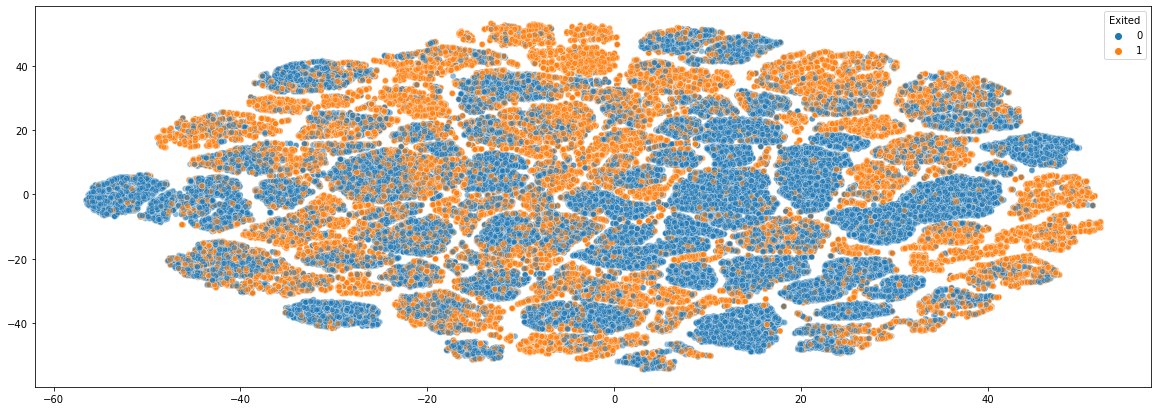

In [193]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = y_train, alpha = 0.5)

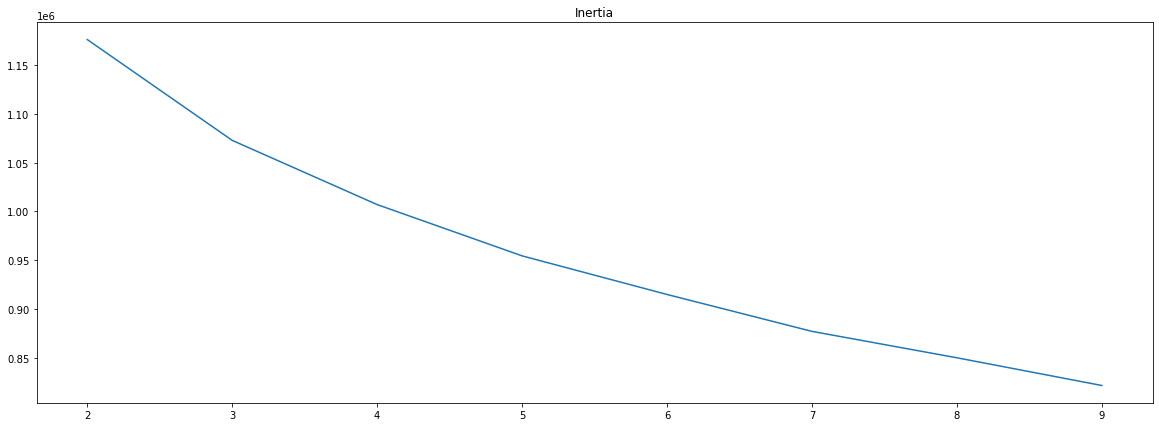

In [194]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(x_train)
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)

plt.title('Inertia')

plt.show()

In [628]:
train_labels = []
for i in [3, 5, 7, 9]:
    km_model = KMeans(n_clusters=i, random_state=100)
    train_labels.append(km_model.fit_predict(x_train))

In [629]:
train_labels_3 = train_labels[0]
train_labels_5 = train_labels[1]
train_labels_7 = train_labels[2]
train_labels_9 = train_labels[3]

<AxesSubplot:>

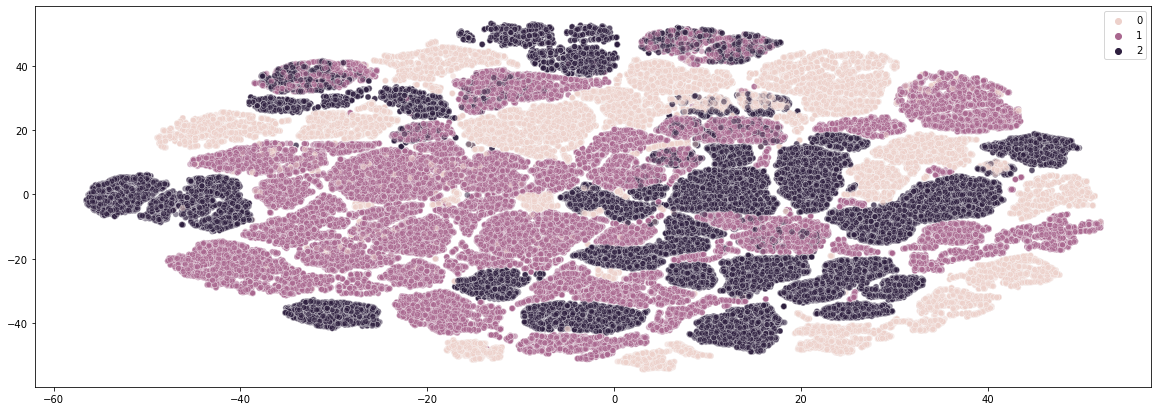

In [198]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_3, alpha = 0.5)

<AxesSubplot:>

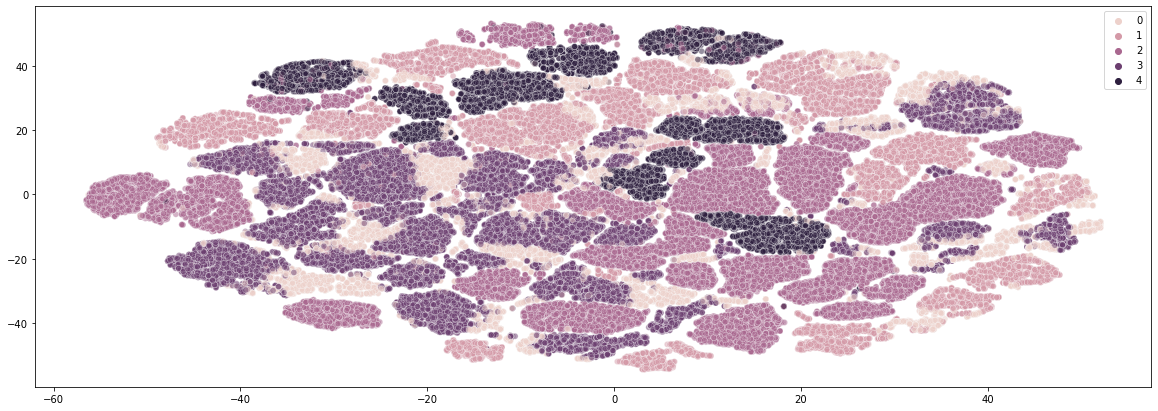

In [199]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_5, alpha = 0.5)

<AxesSubplot:>

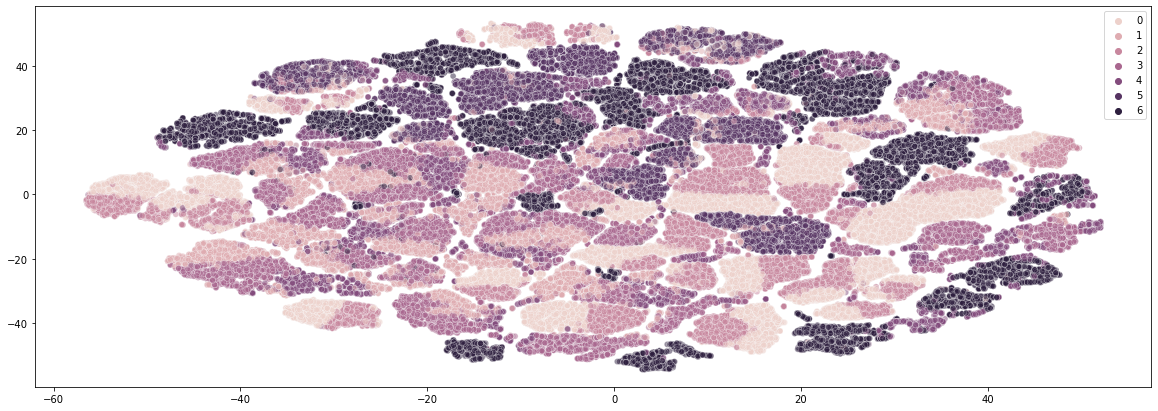

In [200]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_7, alpha = 0.5)

<AxesSubplot:>

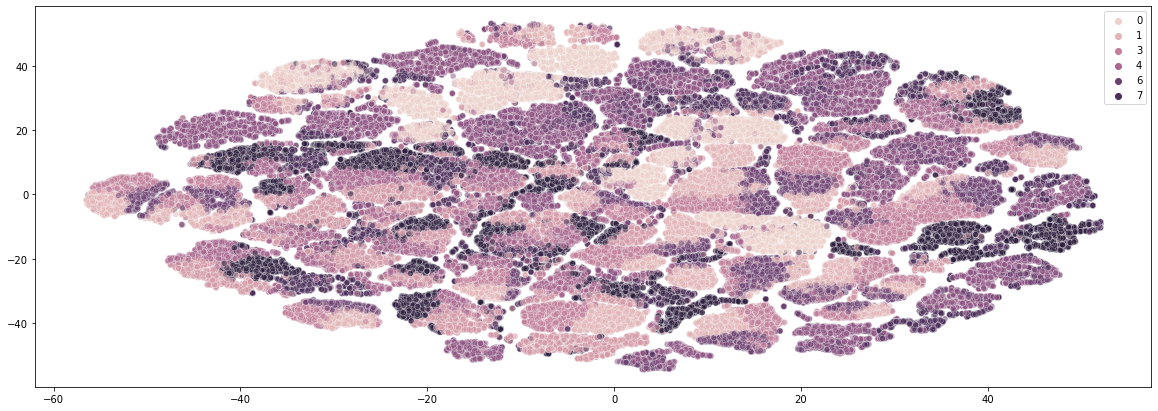

In [201]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_9, alpha = 0.5)

In [630]:
# добавим в датасет кластеризацию на 3, 4 и 6 кластеров
x_train['labels_3'], x_train['labels_5'], x_train['labels_7'], x_train['labels_9'] = train_labels_3, train_labels_5, train_labels_7, train_labels_9

In [631]:
pca = PCA(n_components=2, random_state=100)

In [632]:
components_train = pca.fit_transform(x_train)

In [633]:
x_train[['comp1', 'comp2']] = components_train

In [634]:
#Функция для приведения тестовых данных в соответствие тренировочным
def test_transform(df):
    
    # добавление отсутствующих столбцов
    
    for el in list(x_train.drop(['labels_3', 'labels_5', 'labels_7', 'labels_9', 'comp1', 'comp2'], axis = 1).columns):
        if el not in list(df.columns):
            df[el] = 0
    
    # Kmeans добавим в тестовый датасет
       
    valid_labels = []
    for i in [3, 5, 7, 9]:
        km_model = KMeans(n_clusters=i, random_state=100)
        km_model.fit(x_train.drop(['labels_3', 'labels_5', 'labels_7', 'labels_9', 'comp1', 'comp2'], axis = 1))
        valid_labels.append(km_model.predict(df))
    valid_labels_3 = valid_labels[0]
    valid_labels_5 = valid_labels[1]
    valid_labels_7 = valid_labels[2]
    valid_labels_9 = valid_labels[3]
    
    df['labels_3'], df['labels_5'], df['labels_7'], df['labels_9'] = valid_labels_3, valid_labels_5, valid_labels_7, valid_labels_9
    
    # pca
    components_valid = pca.transform(df)
    df[['comp1', 'comp2']] = components_valid
    
    return df

In [635]:
x_train.head()

Age   Balance  NumOfProducts  EstimatedSalary  CreditScore  \
64761   0.211354  1.208464      -1.013348         0.080299     2.141560   
130819  0.662456  1.311147      -1.013348         0.680038     0.618523   
113809 -0.690850  0.894096      -1.013348         0.277906    -1.466290   
109541  2.579638  1.356669       0.814298        -1.297741     0.943105   
86722  -0.916401  0.882952      -1.013348         0.560143     0.668459   

          Tenure  HasCrCard  IsActiveMember  Geography_France  \
64761  -0.719973        1.0             0.0                 0   
130819  1.061827        1.0             1.0                 0   
113809  0.349107        1.0             0.0                 1   
109541 -1.076334        0.0             0.0                 0   
86722  -0.363613        1.0             1.0                 0   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  \
64761                   1                0              1            0   
130819                  1                0              0            1   
113809                  0                0              0            1   
109541                  0                1              1            0   
86722                   1                0              0            1   

        labels_3  labels_5  labels_7  labels_9     comp1     comp2  
64761          2         1         5         6  1.385900 -3.067501  
130819         2         1         6         1 -3.633563 -2.933108  
113809         2         1         6         1 -3.424996 -2.686540  
109541         2         3         3         5  1.555186 -0.291594  
86722          2         1         5         6  1.276320 -2.873553

In [636]:
x_valid.head()

Age   Balance  NumOfProducts  EstimatedSalary  CreditScore  \
36760  -0.465299 -0.883163       0.814298        -1.006880    -0.567448   
144237 -0.352523  0.794808      -1.013348         1.158428     0.668459   
80753  -0.239748  0.996103      -1.013348        -1.195073     0.531136   
97780  -0.014197  0.355852      -1.013348         0.349654    -0.629868   
16845  -1.480278  1.445265      -1.013348        -1.031728     1.392526   

          Tenure  HasCrCard  IsActiveMember  Geography_France  \
36760  -1.789054        1.0             1.0                 1   
144237 -1.076334        1.0             1.0                 1   
80753  -1.432694        1.0             0.0                 0   
97780   0.349107        1.0             1.0                 1   
16845   0.705467        1.0             0.0                 1   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
36760                   0                0              0            1  
144237                  0                0              0            1  
80753                   1                0              1            0  
97780                   0                0              1            0  
16845                   0                0              1            0

In [637]:
x_valid = test_transform(x_valid)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7d77027820>
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

In [638]:
x_valid.head()

Age   Balance  NumOfProducts  EstimatedSalary  CreditScore  \
36760  -0.465299 -0.883163       0.814298        -1.006880    -0.567448   
144237 -0.352523  0.794808      -1.013348         1.158428     0.668459   
80753  -0.239748  0.996103      -1.013348        -1.195073     0.531136   
97780  -0.014197  0.355852      -1.013348         0.349654    -0.629868   
16845  -1.480278  1.445265      -1.013348        -1.031728     1.392526   

          Tenure  HasCrCard  IsActiveMember  Geography_France  \
36760  -1.789054        1.0             1.0                 1   
144237 -1.076334        1.0             1.0                 1   
80753  -1.432694        1.0             0.0                 0   
97780   0.349107        1.0             1.0                 1   
16845   0.705467        1.0             0.0                 1   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  \
36760                   0                0              0            1   
144237                  0                0              0            1   
80753                   1                0              1            0   
97780                   0                0              1            0   
16845                   0                0              1            0   

        labels_3  labels_5  labels_7  labels_9     comp1     comp2  
36760          1         4         1         4  1.376893  2.715862  
144237         2         1         5         6  1.311213 -2.762304  
80753          2         1         5         7  2.626881 -3.226659  
97780          2         1         6         1 -3.366842 -2.563992  
16845          2         1         6         7  2.272991 -3.937181

<AxesSubplot:>

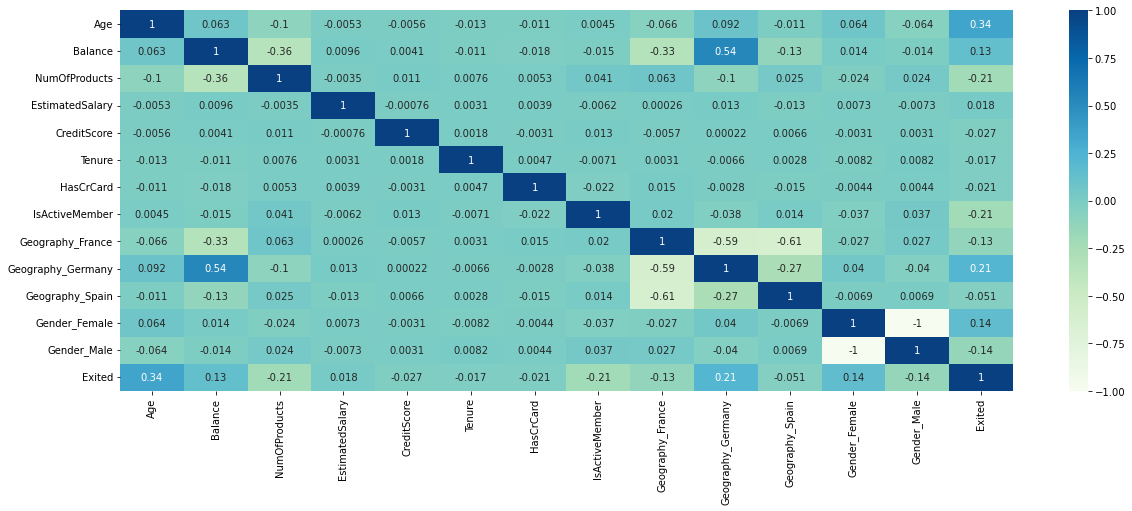

In [639]:
sns.heatmap(df_for_balancing.corr(), annot = True, cmap = 'GnBu')

# Классические модели

In [646]:
# class_weights=[1, 3.5], reg_lambda = 3, n_estimators = 5000, max_depth = 5, eta = 0.1, silent=True, random_state=21

In [643]:
cat_model = catb.CatBoostClassifier(silent=True, random_state=21)

cat_model.fit(x_train, y_train)

y_train_pred = cat_model.predict(x_train)
y_valid_pred = cat_model.predict(x_valid)
y_valid_pred_probs = cat_model.predict_proba(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     97629
           1       0.83      0.81      0.82     78438

    accuracy                           0.84    176067
   macro avg       0.84      0.84      0.84    176067
weighted avg       0.84      0.84      0.84    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     32484
           1       0.59      0.75      0.66      8775

    accuracy                           0.83     41259
   macro avg       0.76      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [662]:
cat_model = catb.CatBoostClassifier(reg_lambda = 3, n_estimators = 500, max_depth = 7, eta = 0.1, silent=True, random_state=21)

cat_model.fit(x_train, y_train)

y_train_pred = cat_model.predict(x_train)
y_valid_pred = cat_model.predict(x_valid)
y_valid_pred_probs = cat_model.predict_proba(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.87      0.86     97629
           1       0.83      0.80      0.82     78438

    accuracy                           0.84    176067
   macro avg       0.84      0.83      0.84    176067
weighted avg       0.84      0.84      0.84    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     32484
           1       0.59      0.75      0.66      8775

    accuracy                           0.83     41259
   macro avg       0.76      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [667]:
XGBclf = XGBClassifier(random_state=21, n_estimators=500, max_depth=5, eta=0.01, gamma = 0.1, alpha = 5)

XGBclf.fit(x_train, y_train)

y_train_pred = XGBclf.predict(x_train)
y_valid_pred = XGBclf.predict(x_valid)
y_valid_pred_probs = XGBclf.predict_proba(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.85      0.83     97629
           1       0.81      0.76      0.78     78438

    accuracy                           0.81    176067
   macro avg       0.81      0.81      0.81    176067
weighted avg       0.81      0.81      0.81    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     32484
           1       0.58      0.75      0.66      8775

    accuracy                           0.83     41259
   macro avg       0.75      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [1031]:
lgbm_model = lgbm.LGBMClassifier(random_state=21)

lgbm_model.fit(x_train, y_train)

y_train_pred = lgbm_model.predict(x_train)
y_valid_pred = lgbm_model.predict(x_valid)
y_valid_pred_probs = lgbm_model.predict_proba(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     97629
           1       0.81      0.77      0.79     78438

    accuracy                           0.82    176067
   macro avg       0.82      0.81      0.81    176067
weighted avg       0.82      0.82      0.82    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     32484
           1       0.58      0.75      0.66      8775

    accuracy                           0.83     41259
   macro avg       0.76      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [678]:
RFclf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=2, min_samples_leaf=3, random_state=21)

RFclf.fit(x_train, y_train)

y_train_pred = RFclf.predict(x_train)
y_valid_pred = RFclf.predict(x_valid)
y_valid_pred_probs = RFclf.predict_proba(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     97629
           1       0.81      0.78      0.80     78438

    accuracy                           0.82    176067
   macro avg       0.82      0.82      0.82    176067
weighted avg       0.82      0.82      0.82    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     32484
           1       0.58      0.75      0.65      8775

    accuracy                           0.83     41259
   macro avg       0.75      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [671]:
# log_reg = LogisticRegression(random_state=21)

# log_reg.fit(x_train, y_train)

# y_train_pred = log_reg.predict(x_train)
# y_valid_pred = log_reg.predict(x_valid)
# y_valid_pred_probs = log_reg.predict_proba(x_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [672]:
# clf = RidgeClassifier(alpha = 1, random_state=21)

# clf.fit(x_train, y_train)

# y_train_pred = clf.predict(x_train)
# y_valid_pred = clf.predict(x_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [673]:
# params = {'n_estimators':[500, 1000, 1500, 2000, 5000],
#           'max_depth':[3, 5, 7], 'learning_rate':[0.01,0.1]}

In [598]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [674]:
# %%time

# rs = RandomizedSearchCV(XGBclf, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(x_train, y_train)

In [675]:
# rs.best_params_

In [676]:
# rs.best_score_

In [600]:
# best_params_lgbm = {'n_estimators': 5000, 'max_depth': 7, 'learning_rate': 0.1}

In [592]:
# lgbm_model = lgbm.LGBMClassifier(n_estimators = 5000, max_depth = 7, learning_rate = 0.1, random_state=21)

# lgbm_model.fit(x_train, y_train)

# y_train_pred = lgbm_model.predict(x_train)
# y_valid_pred = lgbm_model.predict(x_valid)
# y_valid_pred_probs = lgbm_model.predict_proba(x_valid)

# get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [749]:
y_valid_pred_probs_lgbm = y_valid_pred_probs[:,1]

In [750]:
y_valid_pred_probs_lgbm

array([0.02106887, 0.12595214, 0.72130605, ..., 0.1819985 , 0.02072663,
       0.93574013])

# NN

In [751]:
x_train.shape

(176067, 19)

In [752]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,BatchNormalization, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, Reshape
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping  

In [957]:
num_epoch = 20

In [966]:
model = Sequential([
    Input(shape=(19)),
    Dense(units=256, activation = 'relu'),
    BatchNormalization(momentum=0.99),
    Dropout(0.3),
    Dense(units=32, activation = 'relu'),
    BatchNormalization(momentum=0.99),
    Dropout(0.3),
    Dense(units=32, activation = 'relu'),
    BatchNormalization(momentum=0.99),
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 256)               5120      
                                                                 
 batch_normalization_44 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_53 (Dropout)        (None, 256)               0         
                                                                 
 dense_90 (Dense)            (None, 32)                8224      
                                                                 
 batch_normalization_45 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_54 (Dropout)        (None, 32)              

In [967]:
model.fit(x_train, y_train, batch_size=256, epochs=num_epoch, 
          validation_data=(x_valid, y_valid))

Epoch 1/20
688/688 [==============================] - 3s 3ms/step - loss: 0.4852 - accuracy: 0.7742 - val_loss: 0.3935 - val_accuracy: 0.8325
Epoch 2/20
688/688 [==============================] - 2s 2ms/step - loss: 0.4403 - accuracy: 0.7999 - val_loss: 0.3761 - val_accuracy: 0.8403
Epoch 3/20
688/688 [==============================] - 2s 2ms/step - loss: 0.4353 - accuracy: 0.8006 - val_loss: 0.3784 - val_accuracy: 0.8380
Epoch 4/20
688/688 [==============================] - 2s 3ms/step - loss: 0.4332 - accuracy: 0.8022 - val_loss: 0.3981 - val_accuracy: 0.8277
Epoch 5/20
688/688 [==============================] - 2s 2ms/step - loss: 0.4313 - accuracy: 0.8036 - val_loss: 0.3881 - val_accuracy: 0.8345
Epoch 6/20
688/688 [==============================] - 2s 2ms/step - loss: 0.4294 - accuracy: 0.8046 - val_loss: 0.3793 - val_accuracy: 0.8380
Epoch 7/20
688/688 [==============================] - 2s 2ms/step - loss: 0.4289 - accuracy: 0.8041 - val_loss: 0.3870 - val_accuracy: 0.8292
Epoch 

In [998]:
train_pred_proba = model.predict(x_train)

5503/5503 [==============================] - 3s 537us/step


In [999]:
train_pred_proba

array([[0.822524  ],
       [0.6776737 ],
       [0.30713937],
       ...,
       [0.1796933 ],
       [0.44306314],
       [0.6591809 ]], dtype=float32)

In [1000]:
valid_pred_proba = model.predict(x_valid)

1290/1290 [==============================] - 1s 529us/step


In [1001]:
valid_pred_proba

array([[0.01664065],
       [0.0955727 ],
       [0.7213736 ],
       ...,
       [0.1822275 ],
       [0.02551388],
       [0.9364599 ]], dtype=float32)

In [1002]:
train_pred = train_pred_proba.round()
valid_pred = valid_pred_proba.round()

In [1003]:
get_classification_report(y_train, train_pred, y_valid, valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     97629
           1       0.80      0.76      0.78     78438

    accuracy                           0.81    176067
   macro avg       0.81      0.81      0.81    176067
weighted avg       0.81      0.81      0.81    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     32484
           1       0.58      0.75      0.66      8775

    accuracy                           0.83     41259
   macro avg       0.75      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [1032]:
y_valid_pred_probs_lgbm = lgbm_model.predict_proba(x_valid)[:,1]
y_valid_pred_probs_cat = cat_model.predict_proba(x_valid)[:,1]
y_valid_pred_probs_xgbclf = XGBclf.predict_proba(x_valid)[:,1]
y_valid_pred_proba_nn = model.predict(x_valid)

1290/1290 [==============================] - 1s 523us/step


In [1033]:
probas = pd.DataFrame(y_valid_pred_proba_nn, columns = ['nn'])

In [1034]:
probas['lgbm'] = y_valid_pred_probs_lgbm
probas['cat'] = y_valid_pred_probs_cat
probas['xgbclf'] = y_valid_pred_probs_xgbclf

In [1035]:
probas['p_mean'] = probas[['lgbm','nn']].mean(axis=1)
probas['p_max'] = probas[['lgbm','nn']].max(axis = 1)
probas['p_min'] = probas[['lgbm','nn']].min(axis = 1)

In [1036]:
probas

nn      lgbm       cat    xgbclf    p_mean     p_max     p_min
0      0.016641  0.021069  0.010463  0.028533  0.018855  0.021069  0.016641
1      0.095573  0.125952  0.092768  0.128981  0.110762  0.125952  0.095573
2      0.721374  0.721306  0.792321  0.740662  0.721340  0.721374  0.721306
3      0.276994  0.180833  0.172467  0.225554  0.228914  0.276994  0.180833
4      0.332995  0.299121  0.192596  0.355700  0.316058  0.332995  0.299121
...         ...       ...       ...       ...       ...       ...       ...
41254  0.156234  0.157878  0.137388  0.171681  0.157056  0.157878  0.156234
41255  0.542989  0.465331  0.377391  0.486386  0.504160  0.542989  0.465331
41256  0.182228  0.181998  0.130714  0.247948  0.182113  0.182228  0.181998
41257  0.025514  0.020727  0.021793  0.029853  0.023120  0.025514  0.020727
41258  0.936460  0.935740  0.938447  0.918975  0.936100  0.936460  0.935740

[41259 rows x 7 columns]

In [1037]:
y_valid_pred = probas.p_mean
y_valid_pred

0        0.018855
1        0.110762
2        0.721340
3        0.228914
4        0.316058
           ...   
41254    0.157056
41255    0.504160
41256    0.182113
41257    0.023120
41258    0.936100
Name: p_mean, Length: 41259, dtype: float64

In [1038]:
get_classification_report(y_train, train_pred, y_valid, valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     97629
           1       0.80      0.76      0.78     78438

    accuracy                           0.81    176067
   macro avg       0.81      0.81      0.81    176067
weighted avg       0.81      0.81      0.81    176067

TEST

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     32484
           1       0.58      0.75      0.66      8775

    accuracy                           0.83     41259
   macro avg       0.75      0.80      0.77     41259
weighted avg       0.85      0.83      0.84     41259



In [1039]:
def prepare_data_test(data, cat_features, scaler):
    X = data[['CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']]

    for cat_colname in cat_features:
        X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)
    X = X.drop(cat_features, axis =1)
    columns = X.columns
    X = pd.concat([pd.DataFrame(scaler.fit_transform(X[['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Tenure']]), columns =['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Tenure']), X.drop(['Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Tenure'], axis = 1)],axis=1)
    
    
    for el in list(x_train.drop(['labels_3', 'labels_5', 'labels_7', 'labels_9', 'comp1', 'comp2'], axis = 1).columns):
        if el not in list(X.columns):
            df[el] = 0
    
    # Kmeans добавим в тестовый датасет
       
    valid_labels = []
    for i in [3, 5, 7, 9]:
        km_model = KMeans(n_clusters=i, random_state=100)
        km_model.fit(x_train.drop(['labels_3', 'labels_5', 'labels_7', 'labels_9', 'comp1', 'comp2'], axis = 1))
        valid_labels.append(km_model.predict(X))
    valid_labels_3 = valid_labels[0]
    valid_labels_5 = valid_labels[1]
    valid_labels_7 = valid_labels[2]
    valid_labels_9 = valid_labels[3]
    
    X['labels_3'], X['labels_5'], X['labels_7'], X['labels_9'] = valid_labels_3, valid_labels_5, valid_labels_7, valid_labels_9
    
    # pca
    components_valid = pca.transform(X)
    X[['comp1', 'comp2']] = components_valid
    
    return X  

In [1040]:
X_test = prepare_data_test(df_test, cat_features = CAT_FEATURES, scaler=scaler)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7ce2d83670>
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

In [1041]:
X_test

Age   Balance  NumOfProducts  EstimatedSalary  CreditScore  \
0      -1.706504 -0.881274       0.820030         0.967874    -0.878176   
1       0.888990 -0.881274      -1.015806        -0.790939     0.329567   
2      -0.465181 -0.881274       0.820030         0.528413    -0.006609   
3      -0.239486 -0.881274      -1.015806         0.032150     0.304665   
4      -0.013791  1.050038      -1.015806         0.539331     1.188684   
...          ...       ...            ...              ...          ...   
110018 -1.029419  0.967796      -1.015806         0.711510    -1.077392   
110019 -0.239486  1.954171      -1.015806        -1.394946    -1.015137   
110020 -0.803724 -0.881274       0.820030        -1.909981     0.690645   
110021 -0.690876 -0.881274      -1.015806         0.924908     0.653292   
110022 -0.126638  0.517848      -1.015806        -1.752390    -0.442393   

          Tenure  HasCrCard  IsActiveMember  Geography_France  \
0      -1.067887        0.0             1.0                 1   
1      -1.067887        1.0             0.0                 1   
2       0.713922        1.0             0.0                 1   
3       1.070284        1.0             0.0                 1   
4       1.783008        1.0             0.0                 0   
...          ...        ...             ...               ...   
110018  0.713922        1.0             1.0                 0   
110019 -0.355164        1.0             1.0                 1   
110020 -1.067887        1.0             0.0                 1   
110021 -0.711526        1.0             1.0                 1   
110022  0.713922        1.0             0.0                 1   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  \
0                       0                0              1            0   
1                       0                0              1            0   
2                       0                0              1            0   
3                       0                0              0            1   
4                       1                0              0            1   
...                   ...              ...            ...          ...   
110018                  0                1              0            1   
110019                  0                0              1            0   
110020                  0                0              0            1   
110021                  0                0              1            0   
110022                  0                0              1            0   

        labels_3  labels_5  labels_7  labels_9     comp1     comp2  
0              1         2         1         4  0.349325  2.428066  
1              0         3         4         2 -1.114330 -0.174245  
2              1         2         0         3 -0.527709  3.412360  
3              0         2         4         2 -1.768472 -0.221185  
4              2         1         6         1 -3.664767 -2.825761  
...          ...       ...       ...       ...       ...       ...  
110018         2         1         6         1 -3.563147 -2.690800  
110019         2         1         5         7  2.522558 -3.341047  
110020         1         4         1         8  5.165271  1.986483  
110021         0         2         4         2 -1.769090 -0.231418  
110022         2         1         6         7  2.512259 -3.760878  

[110023 rows x 19 columns]

In [1046]:
y_valid_pred_probs_lgbm = lgbm_model.predict_proba(X_test)[:,1]
y_valid_pred_probs_cat = cat_model.predict_proba(X_test)[:,1]
y_valid_pred_probs_xgbclf = XGBclf.predict_proba(X_test)[:,1]
y_valid_pred_proba_nn = model.predict(X_test)

3439/3439 [==============================] - 2s 541us/step


In [1047]:
probas = pd.DataFrame(y_valid_pred_proba_nn, columns = ['nn'])

In [1048]:
probas['lgbm'] = y_valid_pred_probs_lgbm
probas['cat'] = y_valid_pred_probs_cat
probas['xgbclf'] = y_valid_pred_probs_xgbclf

In [1049]:
probas

nn      lgbm       cat    xgbclf
0       0.062148  0.099540  0.096130  0.053555
1       0.939658  0.930786  0.938213  0.929599
2       0.085856  0.068177  0.055462  0.086893
3       0.420782  0.506326  0.478626  0.532634
4       0.621820  0.649674  0.638643  0.636912
...          ...       ...       ...       ...
110018  0.109302  0.111165  0.084506  0.125236
110019  0.205500  0.206173  0.299198  0.224188
110020  0.031086  0.043025  0.046993  0.047399
110021  0.359156  0.353193  0.339150  0.360516
110022  0.378873  0.367487  0.264972  0.419890

[110023 rows x 4 columns]

In [1050]:
probas['p_mean'] = probas[['lgbm','nn']].mean(axis=1)
probas['p_max'] = probas[['lgbm','nn']].max(axis = 1)
probas['p_min'] = probas[['lgbm','nn']].min(axis = 1)

In [1051]:
probas

nn      lgbm       cat    xgbclf    p_mean     p_max     p_min
0       0.062148  0.099540  0.096130  0.053555  0.080844  0.099540  0.062148
1       0.939658  0.930786  0.938213  0.929599  0.935222  0.939658  0.930786
2       0.085856  0.068177  0.055462  0.086893  0.077017  0.085856  0.068177
3       0.420782  0.506326  0.478626  0.532634  0.463554  0.506326  0.420782
4       0.621820  0.649674  0.638643  0.636912  0.635747  0.649674  0.621820
...          ...       ...       ...       ...       ...       ...       ...
110018  0.109302  0.111165  0.084506  0.125236  0.110233  0.111165  0.109302
110019  0.205500  0.206173  0.299198  0.224188  0.205836  0.206173  0.205500
110020  0.031086  0.043025  0.046993  0.047399  0.037055  0.043025  0.031086
110021  0.359156  0.353193  0.339150  0.360516  0.356175  0.359156  0.353193
110022  0.378873  0.367487  0.264972  0.419890  0.373180  0.378873  0.367487

[110023 rows x 7 columns]

In [1052]:
df_test

id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
0       165034    15773898   Lucchese          586    France  Female  23.0   
1       165035    15782418       Nott          683    France  Female  46.0   
2       165036    15807120         K?          656    France  Female  34.0   
3       165037    15808905  O'Donnell          681    France    Male  36.0   
4       165038    15607314    Higgins          752   Germany    Male  38.0   
...        ...         ...        ...          ...       ...     ...   ...   
110018  275052    15662091      P'eng          570     Spain    Male  29.0   
110019  275053    15774133        Cox          575    France  Female  36.0   
110020  275054    15728456      Ch'iu          712    France    Male  31.0   
110021  275055    15687541   Yegorova          709    France  Female  32.0   
110022  275056    15663942       Tuan          621    France  Female  37.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0            2       0.00              2        0.0             1.0   
1            2       0.00              1        1.0             0.0   
2            7       0.00              2        1.0             0.0   
3            8       0.00              1        1.0             0.0   
4           10  121263.62              1        1.0             0.0   
...        ...        ...            ...        ...             ...   
110018       7  116099.82              1        1.0             1.0   
110019       4  178032.53              1        1.0             1.0   
110020       2       0.00              2        1.0             0.0   
110021       3       0.00              1        1.0             1.0   
110022       7   87848.39              1        1.0             0.0   

        EstimatedSalary    Exited  
0             160976.75  0.099540  
1              72549.27  0.939658  
2             138882.09  0.086893  
3             113931.57  0.532634  
4             139431.00  0.649674  
...                 ...       ...  
110018        148087.62  0.125236  
110019         42181.68  0.299198  
110020         16287.38  0.047399  
110021        158816.58  0.360516  
110022         24210.56  0.419890  

[110023 rows x 14 columns]

In [1058]:
df_test['Exited'] = probas['p_mean']

In [1054]:
df_test.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [1055]:
submission = df_test.drop(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'], axis = 1)

In [1056]:
submission

id    Exited
0       165034  0.099540
1       165035  0.939658
2       165036  0.085856
3       165037  0.506326
4       165038  0.649674
...        ...       ...
110018  275052  0.111165
110019  275053  0.206173
110020  275054  0.043025
110021  275055  0.359156
110022  275056  0.378873

[110023 rows x 2 columns]

In [1057]:
submission.to_csv('submission.csv', index=False)